Install the [lifelines](https://lifelines.readthedocs.io) library

In [1]:
!pip install lifelines

     |████████████████████████████████| 409kB 4.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/a0/76/68bc3374ffa2d8d3dfd440fe94158fa8aa2628670fa38bdaf186c9af0d94/matplotlib-3.1.2-cp37-cp37m-macosx_10_9_x86_64.whl
  Created wheel for autograd: filename=autograd-1.3-cp37-none-any.whl size=47990 sha256=a14ecb3ba1b6a4626c2721a672f67abab2d2726c463406a31951fcff0effe5d6
  Stored in directory: /Users/strucka/Library/Caches/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
Successfully built autograd
  Found existing installation: matplotlib 2.2.2
    Uninstalling matplotlib-2.2.2:
      Successfully uninstalled matplotlib-2.2.2


In [2]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

import pandas
import gripql

conn = gripql.Connection("https://bmeg.io/api", credential_file="bmeg_credentials.json")
G = conn.graph("rc5")

Look at the TCGA-BRCA cohort, and find all of the cases where there is a recorded `days_to_death`

In [3]:
q = G.query().V("Project:TCGA-BRCA").out("cases")

data = {}
for i in q:
    if i.data.gdc_attributes.demographic is not None and i.data.gdc_attributes.demographic.vital_status == "Dead":
        if 'days_to_death' in i.data.gdc_attributes.demographic:
            data[ i.gid ] = i.data.gdc_attributes.demographic.days_to_death
survival = pandas.Series(data)

[INFO]	2020-01-14 14:18:49,810	1,098 results received in 0 seconds


Gene ensembl gene id for `TP53`

In [5]:
gene = G.query().V().hasLabel("Gene").has(gripql.eq("symbol", "TP53")).execute()[0].data.gene_id
print(gene)

[INFO]	2020-01-14 14:19:08,643	1 results received in 0 seconds


ENSG00000141510


Starting from the cases with attached survival information, find all of the cases that have a mutation in the gene on interest

In [7]:
q = G.query().V(list(survival.keys())).as_("case").out("samples").out("aliquots").out("somatic_callsets").out("alleles")
q = q.has(gripql.eq("ensembl_gene", gene))
q = q.select("case").distinct("$._gid").render("$._gid")
mut_cases = list(q)

[INFO]	2020-01-14 14:19:47,044	52 results received in 2 seconds


Plot a Kaplan Meirer curve to demonstrate the different in survival of the somatic mutation group and those with no somatic mutation.

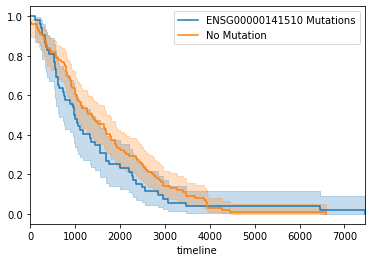

In [8]:
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
kmf.fit(survival[mut_cases], label="%s Mutations" % (gene))
ax = kmf.plot(ax=ax)
kmf.fit(survival[ survival.index.difference(mut_cases) ], label="No Mutation")
kmf.plot(ax=ax)